## Importing the required libraries


In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import resampy

In [3]:
from keras import regularizers
import os

In [4]:
mylist= os.listdir('dataset/merged')

In [5]:
type(mylist)

list

In [6]:
len(mylist)

1920

In [7]:
print(mylist[12])

03-01-01-01-01-01-13.wav


In [8]:
print(mylist[400][6:-16])


03


## Plotting the audio file's waveform and its spectrogram

In [9]:
data, sampling_rate = librosa.load('dataset/merged/03-01-01-01-01-01-13.wav')

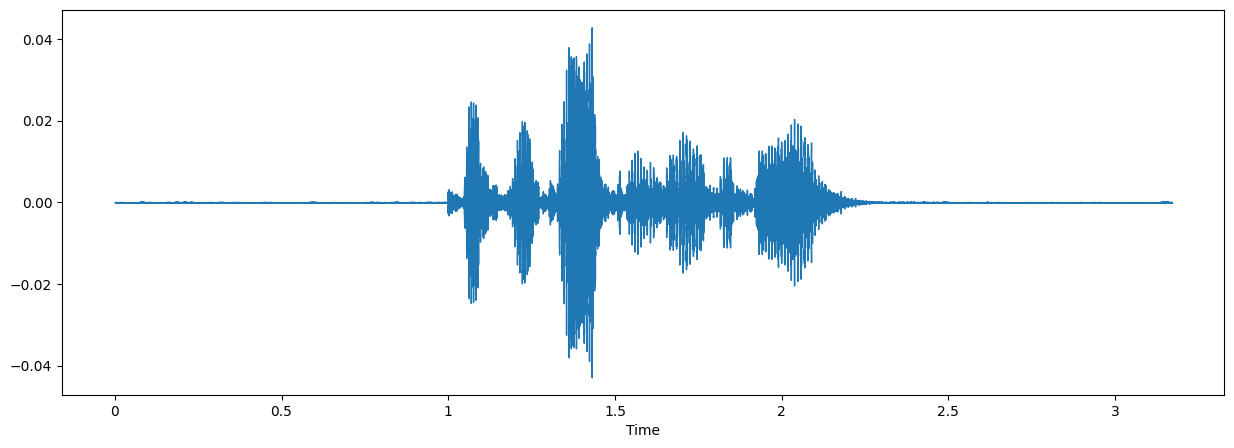

In [9]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))

librosa.display.waveshow(data, sr=sampling_rate)


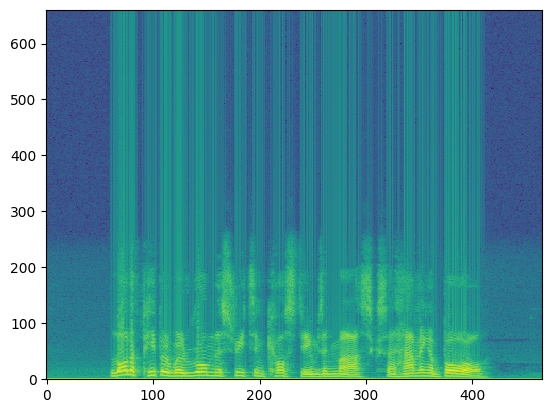

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('dataset/savee_raw/a13.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)
"""
hamming is done to reduce spectral leakage(false peak while truncation to appear in signal specturm) 

improves time resolution
"""

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

<h1>Setting the Labels</h1>

In [8]:
len(mylist)

1920

In [9]:
print(mylist[0])

03-01-01-01-01-01-01.wav


In [10]:
feeling_list=[]
count = 0

for item in mylist:
    if item[6:-16]=='01' and int(item[18:-4])%2==0:
        feeling_list.append('female_neutral')
    elif item[6:-16]=='01' and int(item[18:-4])%2==1:
        feeling_list.append('male_neutral')
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    if item[6:-16]=='07' and int(item[18:-4])%2==0:
        feeling_list.append('female_disgust')
    elif item[6:-16]=='07' and int(item[18:-4])%2==1:
        feeling_list.append('male_disgust')
    if item[6:-16]=='08' and int(item[18:-4])%2==0:
        feeling_list.append('female_surprise')
    elif item[6:-16]=='08' and int(item[18:-4])%2==1:
        feeling_list.append('male_surprise')
    elif item[3:4]=='a':
        feeling_list.append('male_angry')
    elif item[3:4] == 'd': 
        feeling_list.append('male_disgust')
    elif item[3:4]=='f':
        feeling_list.append('male_fearful')
    elif item[3:4]=='h':
        feeling_list.append('male_happy')
    elif item[3:4]=='n':
        feeling_list.append('neutral')
    elif item[3:5]=='sa':
        feeling_list.append('male_sad')
    elif item[3:5]=='su':
        feeling_list.append('male_surprise')

In [11]:
len(feeling_list)

1920

In [12]:
len(feeling_list)
#getting count of all unique values of dataframe
import pandas as pd
import numpy as np
from collections import Counter
Counter(feeling_list)


Counter({'male_neutral': 48,
         'female_neutral': 48,
         'male_calm': 96,
         'female_calm': 96,
         'male_happy': 156,
         'female_happy': 96,
         'male_sad': 156,
         'female_sad': 96,
         'male_angry': 156,
         'female_angry': 96,
         'male_fearful': 156,
         'female_fearful': 96,
         'male_disgust': 156,
         'female_disgust': 96,
         'male_surprise': 156,
         'female_surprise': 96,
         'neutral': 120})

In [13]:
#dataframe creation of labels
labels = pd.DataFrame(feeling_list)

In [14]:
labels[:10]

,0
0,male_neutral
1,female_neutral
2,male_neutral
3,female_neutral
4,male_neutral
5,female_neutral
6,male_neutral
7,female_neutral
8,male_neutral
9,female_neutral


In [15]:
labels.shape

(1920, 1)

<p><b> all the labels for the whole data transformed into dataframe </p>

<h1><b>Features Extraction from audio files</b></h1>

In [16]:
import librosa

In [17]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
        X, sample_rate = librosa.load('dataset/merged/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [18]:
df[:5]

,feature
0,"[-65.801285, -65.801285, -65.801285, -65.80128..."
1,"[-63.214157, -63.214157, -63.214157, -63.21415..."
2,"[-60.258987, -60.258987, -60.258987, -60.25898..."
3,"[-66.48846, -66.48846, -66.48846, -66.48846, -..."
4,"[-62.027878, -60.52594, -64.739456, -66.27164,..."


In [19]:
df.shape

(1920, 1)

In [20]:
#saving df to csv
df.to_csv('mfcc_extracted_features.csv', index=False)

In [21]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [22]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,-58.300411,-62.295700,-64.930496,-65.332520,-64.117332,-64.320320,-64.971794,-63.156208,-64.258797,-64.468193
1,-63.214157,-63.214157,-63.214157,-63.214157,-63.214157,-63.167240,-63.385445,-63.461830,-63.336105,-63.204216,...,-50.994545,-53.428989,-53.139889,-52.854271,-55.248135,-57.682434,-57.166496,-57.040077,-56.105301,-59.386353
2,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,...,-51.362526,-50.511784,-49.082012,-47.701584,-48.795414,-52.424294,-54.828476,-52.233757,-49.679409,-49.952641
3,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.527412,-66.554977,-66.534813,-66.488457,...,-61.150002,-62.122272,-64.444450,-65.315735,-65.285492,-65.365860,-64.971207,-64.157776,-64.913437,-66.488457
4,-62.027878,-60.525940,-64.739456,-66.271637,-61.207905,-60.241585,-62.637955,-63.144920,-60.527340,-59.102253,...,-54.662369,-54.736412,-50.871803,-51.928799,-56.389351,-57.153385,-54.602703,-54.804359,-60.364048,-64.864937


In [23]:
newdf = pd.concat([df3,labels], axis=1)

In [24]:
newdf.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,-62.295700,-64.930496,-65.332520,-64.117332,-64.320320,-64.971794,-63.156208,-64.258797,-64.468193,male_neutral
1,-63.214157,-63.214157,-63.214157,-63.214157,-63.214157,-63.167240,-63.385445,-63.461830,-63.336105,-63.204216,...,-53.428989,-53.139889,-52.854271,-55.248135,-57.682434,-57.166496,-57.040077,-56.105301,-59.386353,female_neutral
2,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,...,-50.511784,-49.082012,-47.701584,-48.795414,-52.424294,-54.828476,-52.233757,-49.679409,-49.952641,male_neutral
3,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.527412,-66.554977,-66.534813,-66.488457,...,-62.122272,-64.444450,-65.315735,-65.285492,-65.365860,-64.971207,-64.157776,-64.913437,-66.488457,female_neutral
4,-62.027878,-60.525940,-64.739456,-66.271637,-61.207905,-60.241585,-62.637955,-63.144920,-60.527340,-59.102253,...,-54.736412,-50.871803,-51.928799,-56.389351,-57.153385,-54.602703,-54.804359,-60.364048,-64.864937,male_neutral


In [25]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [26]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,-65.801285,...,-62.295700,-64.930496,-65.332520,-64.117332,-64.320320,-64.971794,-63.156208,-64.258797,-64.468193,male_neutral
1,-63.214157,-63.214157,-63.214157,-63.214157,-63.214157,-63.167240,-63.385445,-63.461830,-63.336105,-63.204216,...,-53.428989,-53.139889,-52.854271,-55.248135,-57.682434,-57.166496,-57.040077,-56.105301,-59.386353,female_neutral
2,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,-60.258987,...,-50.511784,-49.082012,-47.701584,-48.795414,-52.424294,-54.828476,-52.233757,-49.679409,-49.952641,male_neutral
3,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.488457,-66.527412,-66.554977,-66.534813,-66.488457,...,-62.122272,-64.444450,-65.315735,-65.285492,-65.365860,-64.971207,-64.157776,-64.913437,-66.488457,female_neutral
4,-62.027878,-60.525940,-64.739456,-66.271637,-61.207905,-60.241585,-62.637955,-63.144920,-60.527340,-59.102253,...,-54.736412,-50.871803,-51.928799,-56.389351,-57.153385,-54.602703,-54.804359,-60.364048,-64.864937,male_neutral


In [27]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
256,-50.271282,-50.995720,-51.829220,-52.794907,-54.578865,-54.933445,-55.669449,-53.561844,-52.725182,-54.366543,...,-43.428017,-44.172173,-44.658562,-44.493324,-47.181900,-43.806587,-41.569176,-44.178867,-48.344662,male_calm
1689,-0.566901,-4.369077,-16.104704,-15.844069,-13.193559,-11.755510,-9.424663,-7.435859,-9.420526,-12.237056,...,-0.017263,-3.681004,-7.145496,-12.952842,-19.307341,-23.355278,-24.478834,-22.006714,-16.098873,male_angry
507,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.778767,-59.407173,...,-56.022518,-55.395840,-55.132851,-55.372890,-55.525581,-56.383175,-58.850967,-58.649082,-57.211784,female_sad
381,-64.255356,-61.614143,-60.199909,-61.399822,-63.011471,-64.362534,-64.340225,-62.381138,-57.205776,-56.507133,...,-61.705254,-61.493019,-60.768204,-58.913017,-60.554581,-57.685722,-55.273006,-57.466591,-61.645164,female_happy
1739,-15.023889,-18.257072,-14.360468,-6.680720,-2.668504,-1.909456,-5.410731,-7.193845,-5.948755,-6.512119,...,-5.241549,-5.398290,-4.489192,-4.170420,-2.760769,-1.080886,-0.033271,0.362063,1.985484,male_happy
844,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,...,-38.703644,-39.578392,-39.625309,-39.157639,-39.267426,-39.749321,-39.749321,-39.749321,-39.749321,male_angry
1803,-16.452084,-18.957005,-28.352657,-28.147655,-28.767750,-30.541573,-30.408884,-30.230984,-30.723162,-31.899061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
358,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,-60.458397,...,-60.458397,-60.458397,-60.458397,-60.191818,-59.208256,-57.309792,-55.104713,-54.681213,-54.903358,male_happy
692,-49.371964,-49.371964,-48.691654,-49.118057,-49.371964,-49.371964,-49.371964,-49.371964,-49.371964,-49.371964,...,-18.209999,-19.958761,-19.833357,-17.306173,-17.336426,-18.782040,-17.926195,-16.162359,-14.912889,male_angry
1239,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,-55.070225,...,-32.852112,-33.526505,-33.494091,-31.880169,-30.941118,-32.393661,-33.499985,-26.582233,-21.128447,female_disgust


In [28]:
rnewdf=rnewdf.fillna(0)

<h1><b>Train-Test split</b></h1>

In [29]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [30]:
print(train.shape)
print(test.shape)

(1552, 217)
(368, 217)


In [31]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
613,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,-65.907913,...,-60.096287,-59.633034,-59.478661,-62.280388,-61.723431,-60.514095,-61.855137,-59.965000,-60.797134,female_sad
412,-57.695641,-57.163166,-56.015766,-56.311836,-53.709763,-54.181461,-56.239876,-54.542351,-53.213047,-53.853477,...,-25.633066,-25.043152,-25.087049,-25.839958,-26.987057,-29.418629,-30.673964,-31.510389,-31.376230,male_happy
988,-44.788425,-40.399704,-40.181438,-40.028927,-41.299805,-40.616398,-38.717003,-37.229496,-36.884445,-37.315342,...,-47.783344,-48.033405,-48.330765,-48.191849,-49.559650,-49.632149,-49.047173,-48.564350,-47.430012,male_fearful
742,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,...,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.391323,-55.448547,male_angry
774,-45.745426,-45.319885,-44.862324,-44.635216,-44.866501,-45.168240,-45.227234,-45.197186,-45.096596,-45.002254,...,-36.568275,-35.480022,-35.930759,-37.780888,-37.848129,-36.825130,-37.508232,-35.337917,-29.328266,male_angry
496,-52.219795,-50.721867,-52.543064,-50.260105,-49.978157,-50.648174,-51.050362,-49.983707,-49.875690,-52.750629,...,-49.750374,-49.917862,-50.196220,-49.470268,-49.892715,-51.203510,-50.348953,-51.837917,-49.345478,male_sad
113,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,-66.240349,...,-65.672478,-66.016243,-65.756752,-65.913422,-65.937187,-65.615692,-64.204575,-64.317787,-66.240349,female_calm
766,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,...,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,-55.448513,male_angry
168,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-57.682072,-56.301693,-58.650566,-63.881496,-63.749794,-65.222809,-65.308594,-67.015755,-68.824036,male_calm
68,-60.745586,-60.745586,-60.745586,-60.474327,-58.077740,-54.391975,-55.843166,-56.456337,-51.504967,-48.770893,...,-54.136539,-51.685612,-53.362179,-54.894985,-56.594727,-58.146015,-54.863777,-54.416885,-59.247845,male_neutral


In [32]:
trainfeatures = train.iloc[:, :-1]

In [33]:
trainfeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
256,-50.271282,-50.995720,-51.829220,-52.794907,-54.578865,-54.933445,-55.669449,-53.561844,-52.725182,-54.366543,...,-45.077217,-43.428017,-44.172173,-44.658562,-44.493324,-47.181900,-43.806587,-41.569176,-44.178867,-48.344662
507,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.866234,-58.778767,-59.407173,...,-57.863869,-56.022518,-55.395840,-55.132851,-55.372890,-55.525581,-56.383175,-58.850967,-58.649082,-57.211784
381,-64.255356,-61.614143,-60.199909,-61.399822,-63.011471,-64.362534,-64.340225,-62.381138,-57.205776,-56.507133,...,-57.566059,-61.705254,-61.493019,-60.768204,-58.913017,-60.554581,-57.685722,-55.273006,-57.466591,-61.645164
844,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,-39.749321,...,-37.268093,-38.703644,-39.578392,-39.625309,-39.157639,-39.267426,-39.749321,-39.749321,-39.749321,-39.749321
1803,-16.452084,-18.957005,-28.352657,-28.147655,-28.767750,-30.541573,-30.408884,-30.230984,-30.723162,-31.899061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
trainlabel = train.iloc[:, -1:]

In [35]:
trainlabel.head()

,0
256,male_calm
507,female_sad
381,female_happy
844,male_angry
1803,male_angry


In [36]:
testfeatures = test.iloc[:, :-1]

In [37]:
testlabel = test.iloc[:, -1:]

In [38]:
testlabel.shape

(368, 1)

In [39]:
#getting unique values of training label
import pandas as pd
import numpy as np
from collections import Counter
Counter(trainlabel.values.ravel().tolist())


Counter({'male_calm': 70,
         'female_sad': 82,
         'female_happy': 77,
         'male_angry': 127,
         'male_happy': 126,
         'female_disgust': 85,
         'male_disgust': 121,
         'male_sad': 131,
         'male_fearful': 125,
         'female_fearful': 75,
         'female_neutral': 37,
         'neutral': 95,
         'female_calm': 81,
         'female_angry': 78,
         'male_surprise': 120,
         'female_surprise': 81,
         'male_neutral': 41})

In [40]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



#convert trainlabel dataframe into numpy array 
lb = LabelEncoder()

X_train = np.array(trainfeatures)
X_test = np.array(testfeatures)

y_train = np_utils.to_categorical(lb.fit_transform(trainlabel))
y_test = np_utils.to_categorical(lb.fit_transform(testlabel))

c:\Users\nites\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\nites\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
y_test.shape

(368, 17)

In [42]:
y_train.shape

(1552, 17)

In [43]:
X_train.shape

(1552, 216)

<h1><b>Changing Dimension for CNN model</b></h1>

In [47]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [45]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(17))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

c:\Users\nites\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                        

In [50]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])